### Semantic features as word embeddings

In [1]:
import numpy as np
import os
import torch

### fMRI data

In [2]:
def get_word_activations(path, skip_lines=0):
    """
        Returns dataset of fMRI word activations
        path            Path to .txt fMRI data vectors (continuous) from Cognival
        context_len     Words before the occurring one
        data            Returned dictionary with key ['word'] -> {'context', 'activations'}
    """
    data = {}
    with open(path, "r") as datafile:
        lines = datafile.readlines()[skip_lines:] # skip header
        for line in tqdm(lines):
            word = line.split(" ")[0]
            activations = np.array([float(x) for x in line.split(" ")[1:]])
            data[word] = {"activations": activations}
    return data

### Predicting

In [3]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

In [4]:
subject = 1
voxels = 1000

# Over all subjects
filename = os.path.join("data", "cognival", "fmri", "nouns", f"{voxels}-random-voxels", f"scaled_{voxels}_mitchell_targets_{1}.txt")
fmriData = get_word_activations(filename, skip_lines = 1)

"""
filename = os.path.join("data", "cognival", "fmri", "pereira", f"{voxels}-random-voxels", f"scaled_{voxels}_pereira_targets_M01.txt")
data2 = get_word_activations(filename, skip_lines = 1)

mitchell_dataset = {}

for key in data1.keys():
    if key not in mitchell_dataset: mitchell_dataset[key] = data1[key]

for key in data2.keys():
    if key not in mitchell_dataset: mitchell_dataset[key] = data2[key]
"""
pass

100%|██████████| 60/60 [00:00<00:00, 2068.59it/s]


### GloVe embeddings

In [5]:
filename = os.path.join("data", "glove.6B", f"glove.6B.100d.txt")
glove_embeddings = get_word_activations(filename, skip_lines = 0)

100%|██████████| 400000/400000 [00:11<00:00, 33740.09it/s]


In [6]:
# Building train set
X = []
Y = []
for word in tqdm(fmriData.keys()):
    if word in glove_embeddings.keys():
        X.append(glove_embeddings[word]["activations"])
        Y.append(fmriData[word]["activations"])

# Fetch fMRI activations from the dataset
X = np.array(X)
Y = np.array(Y)

100%|██████████| 60/60 [00:00<?, ?it/s]


In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.03, random_state=42)

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(58, 100) (2, 100)
(58, 1000) (2, 1000)


In [8]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.neural_network import MLPRegressor

# make_pipeline(StandardScaler(with_mean=False), LinearRegression())
predictors = [LinearRegression() for i in range(voxels)]
scores = []

# One predictor per voxel
i = 0
for model in tqdm(predictors):
    model.fit(X_train, y_train[:, i])
    scores.append(model.score(X_test, y_test[:, i]))
    i += 1

scores = np.array(scores)

100%|██████████| 1000/1000 [00:02<00:00, 431.38it/s]


In [9]:
# Picking the best 100 predictors per voxel
K = 100
ind = np.argpartition(scores, -K)[-K:]

print("min \t\t max \t\t mean")
print(f"{np.min(scores[ind]):.4f} \t\t {np.max(scores[ind]):.4f} \t {np.mean(scores[ind]):.4f}")

min 		 max 		 mean
0.1336 		 0.9843 	 0.5855


Test RDMs R^2:	PearsonRResult(statistic=0.09427957750112809, pvalue=4.292153924534385e-08)


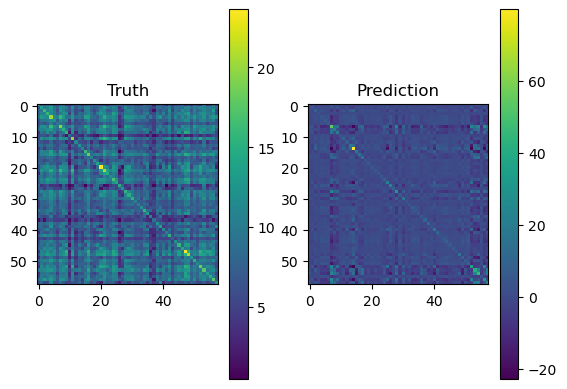

In [10]:
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

def best_K_predict(X, indices, predictors):
    predictors = [predictors[idx] for idx in indices]
    y_hat = np.array([predictor.predict(X) for predictor in predictors]) # voxels, sample
    return y_hat.reshape(y_hat.shape[1], y_hat.shape[0]) # sample, voxels


y_hat = best_K_predict(X_train, ind, predictors)
y = y_train[:, ind]

RDM_hat = np.matmul(y_hat, np.matrix.transpose(y_hat))
# RDM_hat = (RDM_hat - RDM_hat.min()) / (RDM_hat.max() - RDM_hat.min())

RDM = np.matmul(y, np.matrix.transpose(y))
# RDM = (RDM - RDM.min()) / (RDM.max() - RDM.min())

test_pearson = pearsonr(
    RDM_hat.flatten(),
    RDM.flatten()
)

print(f"Test RDMs R^2:\t{test_pearson}")

plt.subplot(121)
plt.title("Truth")
plt.imshow(RDM)
plt.colorbar()

plt.subplot(122)
plt.title("Prediction")
plt.imshow(RDM_hat)
plt.colorbar()